In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import PCA
from sklearn.decomposition import PCA

ModuleNotFoundError: No module named 'pandas'

In [3]:
from biotite.structure.io.pdb import PDBFile
import requests

afdb_link = "https://alphafold.ebi.ac.uk/files/AF-A7YWM6-F1-model_v4.pdb"
afdb_path = "./AF-A7YWM6-F1-model_v4.pdb"
with open(afdb_path, "wb") as f:
    f.write(requests.get(afdb_link).content)
afdb_structure = PDBFile.read(afdb_path)

In [6]:
afdb_structure.get_structure(model=1)

ValueError: The file has 0 models, the given model 1 does not exist

## 1. Defluorinating halogenases - small set 

In [2]:
deepfri_output = "/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/Metagenomic-DeepFRI/notebooks/data/248_HAD_dehalogenase_subset_result/results.tsv"
metadata = "/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/Metagenomic-DeepFRI/notebooks/data/248_HAD_dehalogenase_subset.csv"

In [3]:
df = pd.read_csv(deepfri_output, sep='\t')
metadata_df = pd.read_csv(metadata, sep=',')

mode = "mf"

sub_df = df.query("DeepFRI_mode == @mode")

feature_table = pd.pivot_table(sub_df, index="Protein", columns="GO_term/EC_number", values="Score").fillna(0)

labels = metadata_df.is_defluorinating
feature_table.index = feature_table.index.str.replace("seq_", "")
# convert to int
feature_table.index = feature_table.index.astype(int) - 1
feature_table = feature_table.sort_index()

In [4]:
df["Protein"] = df["Protein"].str.replace("seq_", "").astype(int) - 1

In [5]:
top_annotations = df.Annotation.value_counts().index[:10]
# show only top annotations
df.query(f"Annotation in @top_annotations")["GO_term/EC_number"].value_counts()

GO_term/EC_number
GO:0006793    16
GO:0006796    15
GO:0016788    15
GO:0044283    14
GO:0006082    13
GO:0043436    13
3.1.3.-       13
GO:0016853    12
GO:0000287    11
GO:0042578    11
Name: count, dtype: int64

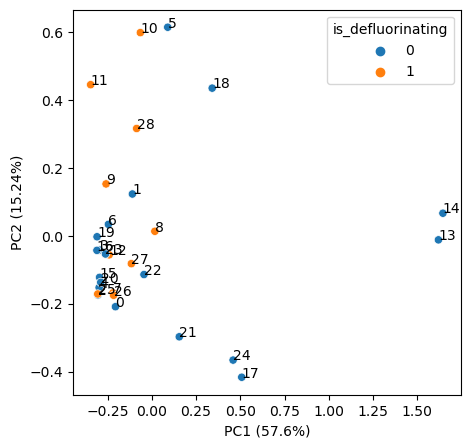

In [6]:
# make a PCA and plot a feature table
pca = PCA(n_components=2)
pca.fit(feature_table)
X_pca = pca.transform(feature_table)

labels = labels[feature_table.index]

# plot the PCA and color by labels
plt.figure(figsize=(5, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels)

# add variance to axes
plt.xlabel(f"PC1 ({round(pca.explained_variance_ratio_[0]*100, 2)}%)")
plt.ylabel(f"PC2 ({round(pca.explained_variance_ratio_[1]*100, 2)}%)")

# add numbers over dots
for i, txt in enumerate(feature_table.index):
    plt.text(X_pca[i, 0], X_pca[i, 1], txt)

plt.show()

**CONCLUSIONS**
- there are definitely non fluorinating haolgenases (13, 14, 17, 21, 24)
- overall the separation is weak

# 2. Identification of dehalogenases among dehalogenase-like-family proteins

In [121]:
start_dataset = "/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/Metagenomic-DeepFRI/notebooks/data/248_HAD_strat_dataset_fixed/results.tsv"
start_df = pd.read_csv(start_dataset, sep='\t')
start_meta = "/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/Metagenomic-DeepFRI/notebooks/data/248_HAD_start_dataset_fixed.csv"
start_meta_df = pd.read_csv(start_meta, sep=',')

full_df = pd.concat([start_df, df])

In [130]:
# select the mode
mode = "mf"
full_molecular_function = full_df.query(f"DeepFRI_mode =='{mode}'")
# convert dataset to matrix
full_feature_table = pd.pivot_table(full_molecular_function, index="Protein", columns="GO_term/EC_number", values="Score").fillna(0)

In [139]:
median_score

Protein
0                                                                                0.128720
1                                                                                0.149715
2                                                                                0.156409
3                                                                                0.126849
4                                                                                0.229427
                                                                                   ...   
wp004693440_1_acinetobacter_johnsonii_protein_4                                  0.113442
wp006686258_1_citrobacter_youngae_protein_7                                      0.108235
wp053428405_1_rossellomorea_marisflavi_protein_8                                 0.152906
wp08718999_1_gordonibacter_urolithinfaciens_protein3                             0.120447
wp118709078_1_enterocloster_aldenensis_faecalibacterium_prausnitzii_protein_1    0.122352
Na

In [152]:
full_df

,Protein,GO_term/EC_number,Score,Annotation,Neural_net,DeepFRI_mode,DB_hit,DB_name,Identity,Coverage
0,MGDP1_MOUSE,GO:0006259,0.178532,DNA metabolic process,gcn,bp,1u7p_D,pdb100_230517,1.0,0.981707
1,MGDP1_MOUSE,GO:0043412,0.173147,macromolecule modification,gcn,bp,1u7p_D,pdb100_230517,1.0,0.981707
2,MGDP1_MOUSE,GO:0051716,0.158628,cellular response to stimulus,gcn,bp,1u7p_D,pdb100_230517,1.0,0.981707
3,MGDP1_MOUSE,GO:0036211,0.135388,protein modification process,gcn,bp,1u7p_D,pdb100_230517,1.0,0.981707
4,MGDP1_MOUSE,GO:0006464,0.134571,cellular protein modification process,gcn,bp,1u7p_D,pdb100_230517,1.0,0.981707
...,...,...,...,...,...,...,...,...,...,...
531,0,GO:0016829,0.152069,lyase activity,cnn,mf,NaN,NaN,NaN,NaN
532,0,GO:0016788,0.150515,"hydrolase activity, acting on ester bonds",cnn,mf,NaN,NaN,NaN,NaN
533,0,GO:0140096,0.128720,"catalytic activity, acting on a protein",cnn,mf,NaN,NaN,NaN,NaN
534,0,GO:0046914,0.109377,transition metal ion binding,cnn,mf,NaN,NaN,NaN,NaN


In [163]:
full_feature_table.index[:30]

Index([           0,            1,            2,            3,            4,
                  5,            6,            7,            8,            9,
                 10,           11,           12,           13,           14,
                 15,           16,           17,           18,           19,
                 20,           21,           22,           23,           24,
                 25,           26,           27,           28, '5NTD_PSEAE'],
      dtype='object', name='Protein')

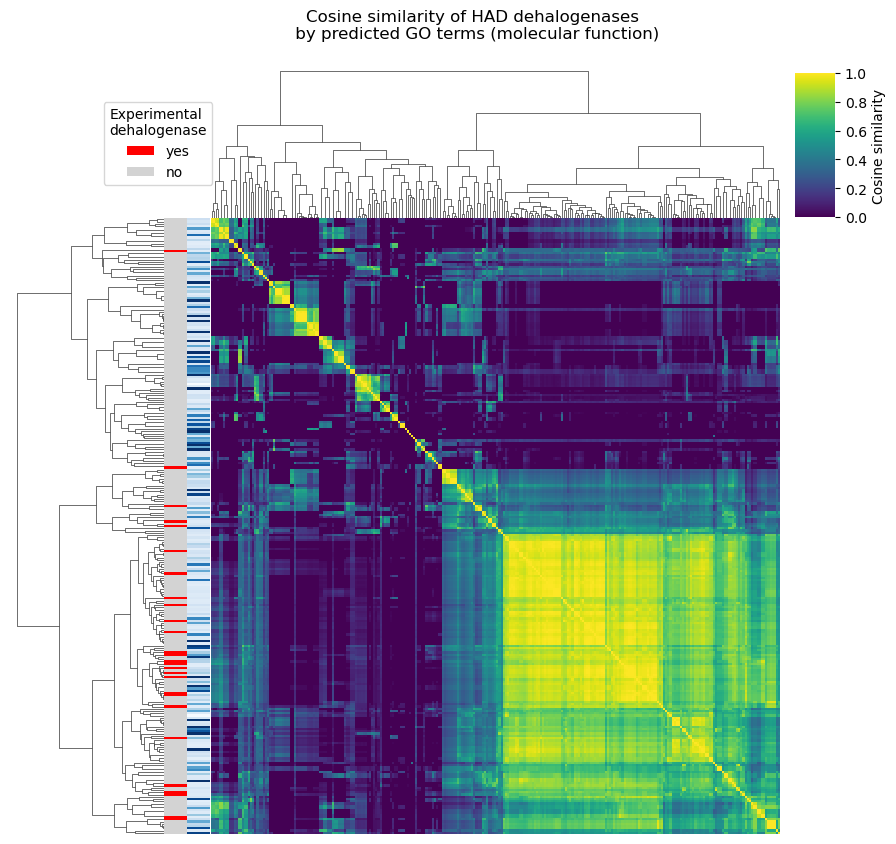

In [159]:
# calculate cosine distances
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage

cosine_distances = pairwise_distances(full, metric="cosine")
# transform to similarity
cosine_similarity = 1 - cosine_distances
link = linkage(cosine_similarity, method="complete")

g = sns.clustermap(cosine_similarity, row_linkage=link, col_linkage=link, figsize=(8, 8),
               cmap="viridis", xticklabels=False, yticklabels=False,
               cbar_kws={"label": "Cosine similarity"},
               cbar_pos=(1.0, 0.79, 0.05, 0.18));

# add legend
for label in ["yes", "no"]:
    g.ax_col_dendrogram.bar(0, 0, color="red" if label == "yes" else "lightgrey", label=label)
g.ax_col_dendrogram.legend(title="Experimental\ndehalogenase", loc="upper left", bbox_to_anchor=(-0.2, 0.8), fontsize=10)

# add suptitle
g.fig.suptitle("Cosine similarity of HAD dehalogenases \n by predicted GO terms (molecular function)", y=1.05, x=0.6);



In [157]:
row_annotation

array([['lightgrey',
        (0.32124567474048443, 0.6151787773933103, 0.8008304498269896, 1.0)],
       ['lightgrey',
        (0.7407920030757401, 0.8436601307189542, 0.9247673971549404, 1.0)],
       ['lightgrey',
        (0.366643598615917, 0.6461822376009227, 0.8185467128027681, 1.0)],
       ['lightgrey',
        (0.6915801614763553, 0.8227450980392157, 0.9075432525951557, 1.0)],
       ['lightgrey',
        (0.8111649365628605, 0.8819530949634755, 0.9488196847366398, 1.0)],
       ['lightgrey',
        (0.31620146097654767, 0.6117339484813534, 0.7988619761630142, 1.0)],
       ['lightgrey',
        (0.8052595155709343, 0.8780161476355247, 0.9468512110726643, 1.0)],
       ['lightgrey',
        (0.8643137254901961, 0.9173856209150326, 0.9665359477124184, 1.0)],
       ['lightgrey',
        (0.828881199538639, 0.8937639369473279, 0.954725105728566, 1.0)],
       ['lightgrey',
        (0.03137254901960784, 0.18823529411764706, 0.4196078431372549, 1.0)],
       ['lightgrey',
        

# Conclusion
The groups of halogenases are heterogeneous according to function vector.

In [155]:
row_annotation

,0,Score
MGDP1_MOUSE,lightgrey,0.575848
MGDP1_SCHPO,lightgrey,0.280244
MGDP1_HUMAN,lightgrey,0.539226
MGDP1_YEAST,lightgrey,0.317610
YQAB_ECOLI,lightgrey,0.204957
...,...,...
0,red,0.128720
3,red,0.126849
22,red,0.135283
1,red,0.149715


# Searching for dehalogenases among dataset
The reasonable approach for task without ground truth data is to calculate functional distances for all proteins and cluster them. Clusters with a lot of experimentally identified dehalogenases are likely to contain more proteins with dehalogenising activity. 

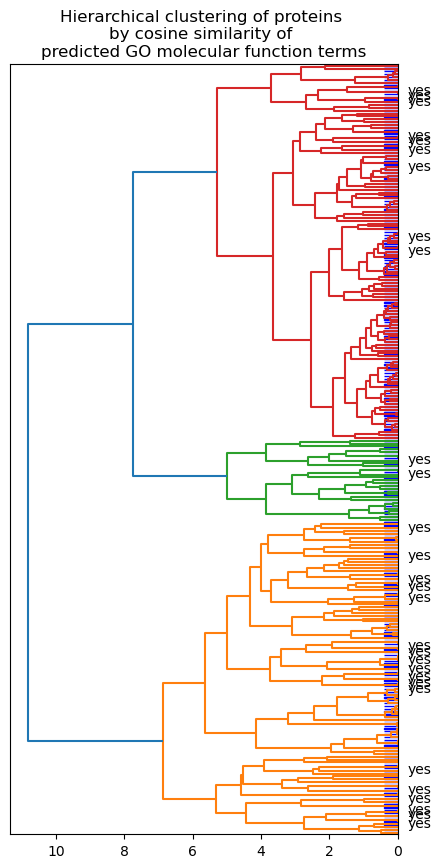

In [37]:
# get clusters
from scipy.cluster.hierarchy import dendrogram
# import rectangle
from matplotlib.patches import Rectangle

plt.figure(figsize=(5, 10))
dendrogram(link, labels=experiment.replace({"no" : ""}).values, orientation="left", leaf_font_size=10)
# plt.xlim(0, 700)
plt.title("Hierarchical clustering of proteins \nby cosine similarity of \npredicted GO molecular function terms")




In [12]:
from scipy.cluster.hierarchy import leaves_list

# get the order of leaves
leaves = leaves_list(link)

In [15]:
subset = full.iloc[leaves]

In [16]:
dense_cluster = subset.tail(30)

In [17]:
candidates = full_df[(full_df.Protein.isin(dense_cluster.index)) & (full_df.DeepFRI_mode == 'mf')].sort_values("Score", ascending=False)

In [18]:
candidate_feature_table = pd.pivot_table(candidates, index="Protein", columns="GO_term/EC_number", values="Score").fillna(0)

In [37]:
candidate_feature_table["experiment"] = ["yes"] * 8 + ["no"] * 22
y = candidate_feature_table["experiment"].values
candidate_feature_table = candidate_feature_table.drop("experiment", axis=1)

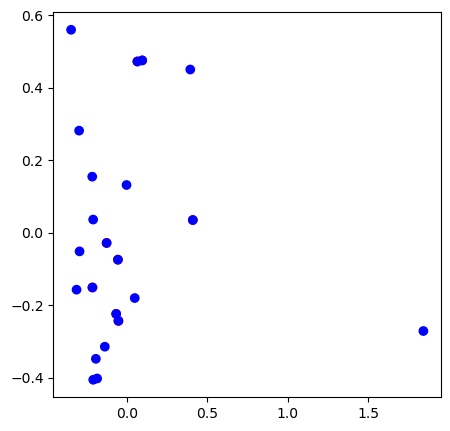

In [63]:
# plot a PCA
pca = PCA(n_components=2)

pca.fit(candidate_feature_table)
X_pca = pca.transform(candidate_feature_table)
colors = {"yes" : "red", "no" : "blue"}
# plot with hover text
plt.figure(figsize=(5, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=[colors[i] for i in y])